In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import pmdarima as pm
from pmdarima.arima import auto_arima
print("pmdarima:", pm.__version__)
print("numpy:", np.__version__)

pmdarima: 2.0.4
numpy: 2.2.4


In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
required_columns = {'Date', 'store', 'product', 'number_sold'}
if not required_columns.issubset(train_df.columns) or not required_columns.issubset(test_df.columns):
    raise ValueError(f"Ожидаются колонки: {required_columns}")

train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

stores = sorted(train_df['store'].unique())  # 7 магазинов
products = sorted(train_df['product'].unique())  # 10 товаров

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
all_results = []
total_combinations = len(stores) * len(products)
count = 0

for st in stores:
    for pr in products:
        count += 1
        subset_train = train_df[(train_df['store'] == st) & (train_df['product'] == pr)].copy()
        subset_test = test_df[(test_df['store'] == st) & (test_df['product'] == pr)].copy()

        if subset_train.empty:
            continue

        subset_train.set_index('Date', inplace=True)

        if not subset_test.empty:
            subset_test.set_index('Date', inplace=True)

        try:
            auto_model = auto_arima(
                subset_train['number_sold'],
                seasonal=True, m=7,
                d=None, D=None,
                start_p=0, max_p=3,
                start_q=0, max_q=3,
                start_P=0, max_P=2,
                start_Q=0, max_Q=2,
                information_criterion='aic',
                trace=False,
                error_action='ignore',
                suppress_warnings=True,
                stepwise=True
            )
            order = auto_model.order
            seasonal_order = auto_model.seasonal_order
        except Exception as e:
            print(f"auto_arima не сработал для store={st}, product={pr}. Ошибка: {e}")
            order = (1, 1, 1)
            seasonal_order = (0, 0, 0, 0)

        try:
            model = SARIMAX(
                subset_train['number_sold'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit(disp=False)
        except Exception as e:
            print(f"Не удалось обучить SARIMAX для store={st}, product={pr}. Ошибка: {e}")
            continue

        if not subset_test.empty:
            forecast_steps = len(subset_test)
            forecast_object = model_fit.get_forecast(steps=forecast_steps)
            forecast_values = forecast_object.predicted_mean
            forecast_values.index = subset_test.index

            actual_values = subset_test['number_sold']

            mse = mean_squared_error(actual_values, forecast_values)
            rmse = np.sqrt(mse)

            try:
                mape_val = mean_absolute_percentage_error(actual_values, forecast_values)
            except ZeroDivisionError:
                mape_val = None

            r2_val = r2_score(actual_values, forecast_values)

            temp_df = pd.DataFrame({
                'Date': forecast_values.index,
                'store': st,
                'product': pr,
                'Actual': actual_values,
                'Forecast': forecast_values,
                'RMSE': rmse,
                'MAPE': mape_val,
                'R2': r2_val,
            })
            all_results.append(temp_df)
            print(f"[{count}/{total_combinations}] Готово: store={st}, product={pr}")

[1/70] Готово: store=0, product=0
[2/70] Готово: store=0, product=1
[3/70] Готово: store=0, product=2
[4/70] Готово: store=0, product=3
[5/70] Готово: store=0, product=4
[6/70] Готово: store=0, product=5
[7/70] Готово: store=0, product=6
[8/70] Готово: store=0, product=7
[9/70] Готово: store=0, product=8
[10/70] Готово: store=0, product=9
[11/70] Готово: store=1, product=0
[12/70] Готово: store=1, product=1
[13/70] Готово: store=1, product=2
[14/70] Готово: store=1, product=3
[15/70] Готово: store=1, product=4
[16/70] Готово: store=1, product=5
[17/70] Готово: store=1, product=6
[18/70] Готово: store=1, product=7
[19/70] Готово: store=1, product=8
[20/70] Готово: store=1, product=9
[21/70] Готово: store=2, product=0
[22/70] Готово: store=2, product=1
[23/70] Готово: store=2, product=2
[24/70] Готово: store=2, product=3
[25/70] Готово: store=2, product=4
[26/70] Готово: store=2, product=5
[27/70] Готово: store=2, product=6
[28/70] Готово: store=2, product=7
[29/70] Готово: store=2, prod

Пример итогового DataFrame:
        Date  store  product  Actual    Forecast       RMSE      MAPE  \
0 2019-01-01      0        0     845  840.280908  36.611009  0.036898   
1 2019-01-02      0        0     851  841.205412  36.611009  0.036898   
2 2019-01-03      0        0     840  840.017251  36.611009  0.036898   
3 2019-01-04      0        0     842  841.931182  36.611009  0.036898   
4 2019-01-05      0        0     845  841.893957  36.611009  0.036898   

         R2  
0 -0.052875  
1 -0.052875  
2 -0.052875  
3 -0.052875  
4 -0.052875  

Результаты прогнозов сохранены в 'forecast_per_store_product.csv'.


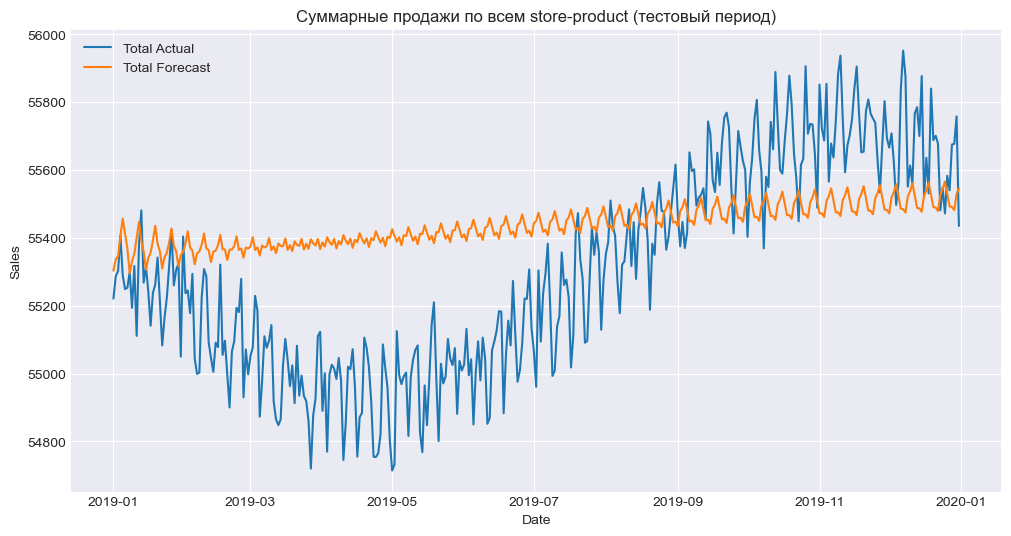


Итоговые метрики (суммарно по всем магазинам и товарам):
RMSE (total): 302.11
MAPE (total): 0.0046 (0.46%)
R2 (total): 0.0234


In [8]:
if all_results:
    results_df = pd.concat(all_results, ignore_index=True)
    print("Пример итогового DataFrame:")
    print(results_df.head())


    results_df.to_csv("forecast_per_store_product.csv", index=False)
    print("\nРезультаты прогнозов сохранены в 'forecast_per_store_product.csv'.")
    daily_agg = results_df.groupby('Date')[['Actual','Forecast']].sum()

    plt.figure(figsize=(12,6))
    plt.plot(daily_agg.index, daily_agg['Actual'], label='Total Actual')
    plt.plot(daily_agg.index, daily_agg['Forecast'], label='Total Forecast')
    plt.title("Суммарные продажи по всем store-product (тестовый период)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

    mse_total = mean_squared_error(daily_agg['Actual'], daily_agg['Forecast'])
    rmse_total = np.sqrt(mse_total)
    try:
        mape_total = mean_absolute_percentage_error(daily_agg['Actual'], daily_agg['Forecast'])
    except ZeroDivisionError:
        mape_total = None
    r2_total = r2_score(daily_agg['Actual'], daily_agg['Forecast'])

    print(f"\nИтоговые метрики (суммарно по всем магазинам и товарам):")
    print(f"RMSE (total): {rmse_total:.2f}")
    if mape_total is not None:
        print(f"MAPE (total): {mape_total:.4f} ({mape_total*100:.2f}%)")
    else:
        print("MAPE (total): не определён (есть нулевые продажи).")
    print(f"R2 (total): {r2_total:.4f}")
else:
    print("Нет результатов")

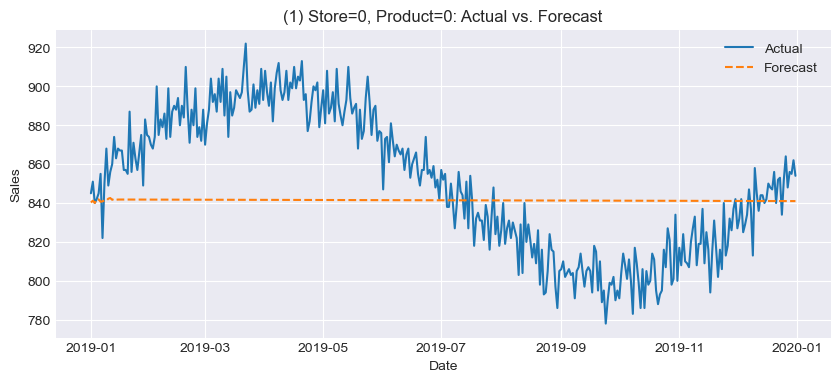

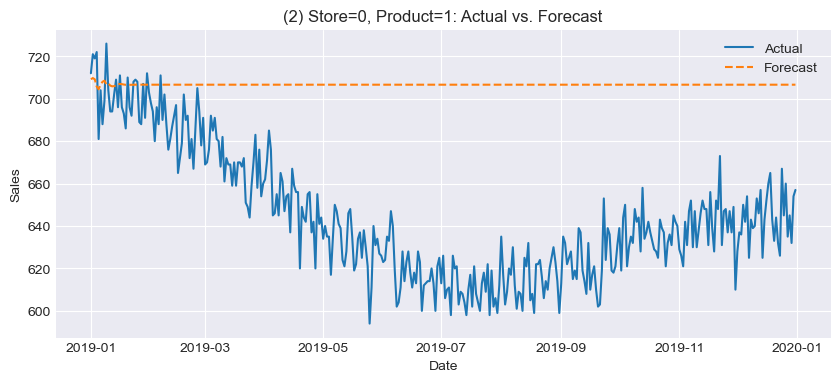

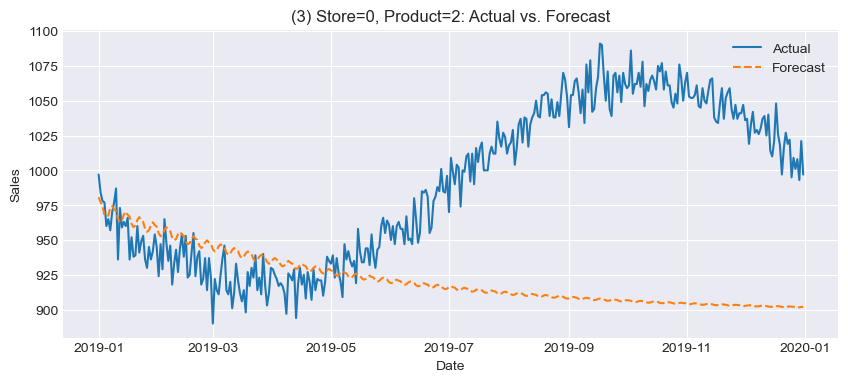

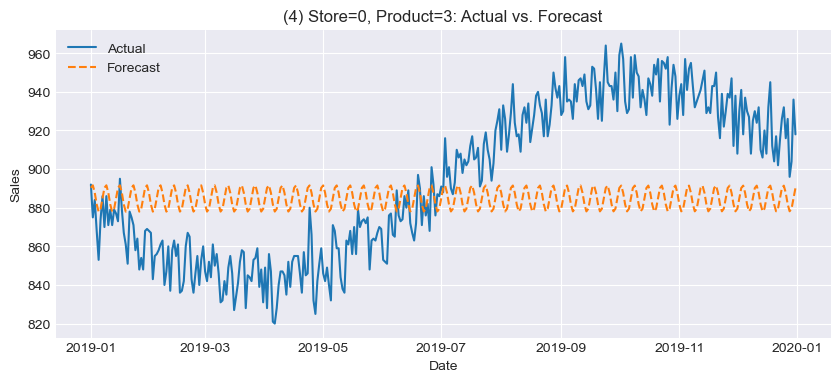

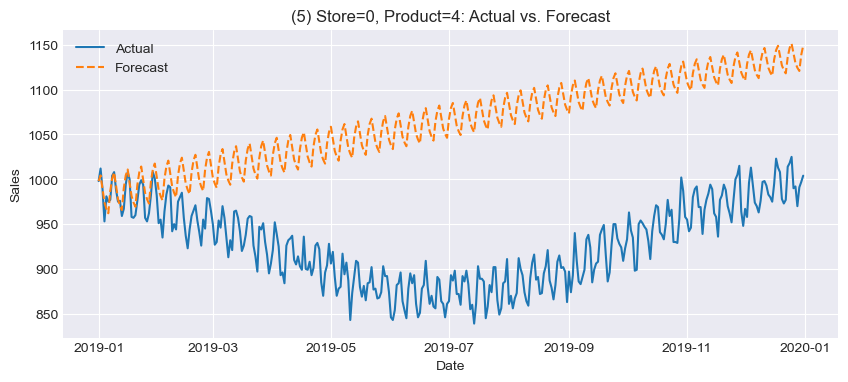

In [9]:
results_df['store'] = results_df['store'].astype(int)
results_df['product'] = results_df['product'].astype(int)
combos = (results_df[['store', 'product']]
          .drop_duplicates()
          .sort_values(['store', 'product'])
          .values.tolist())

n_combinations = 5

for i, (st, pr) in enumerate(combos[:n_combinations], start=1):
    subset = results_df[(results_df['store'] == st) & (results_df['product'] == pr)].copy()

    subset = subset.sort_values('Date').set_index('Date')

    plt.figure(figsize=(10, 4))
    plt.plot(subset.index, subset['Actual'], label='Actual')
    plt.plot(subset.index, subset['Forecast'], label='Forecast', linestyle='--')

    plt.title(f"({i}) Store={st}, Product={pr}: Actual vs. Forecast")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()